In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from functools import partial

from tree_extraction import Aho
from compute_pam import compute_combo_tensor, get_alpha
from sim_data import HPAM2Sampler
from example_graphs import make_tree
from utils import bfs_layout

In [2]:
import sys, os
sys.path.append(os.path.abspath('../anchor-word-recovery/'))

In [3]:
from learn_topics import Analysis, Params

In [4]:
def nice_tree_plot(t, ax = None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    if t is None:
        return
    draw_kwargs = dict(with_labels=True, pos=bfs_layout(t))
    draw_kwargs.update(kwargs)
    nx.draw(t, **draw_kwargs)

In [5]:
tree = make_tree([3,3,3])

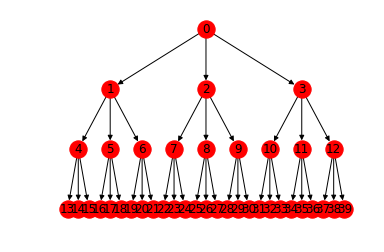

In [6]:
nice_tree_plot(tree)

In [18]:
# TODO: extract tree from simulated data
# TODO: extract tree from real data
# TODO: run the tree-building sequence on the above results